### Look at relationship between choice and preference decoders for some feature
- First pass: Just look at cosine similarity

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy

In [2]:
sig_unit_level = "pref_99th_window_filter_drift"

In [3]:
MODE_TO_DIRECTION_LABELS = {
    "pref": {"high": "High X", "low": "High Not X"},
    "conf": {"high": "High", "low": "Low"},
    "choice_int": {"high": "Chose", "low": "Not Chose"},
    "choice": {"high": "Chose", "low": "Not Chose"},
    "reward": {"high": "Correct", "low": "Incorrect"}

}


def get_weights(args):
    high_idx = MODE_TO_CLASSES[args.mode].index(MODE_TO_DIRECTION_LABELS[args.mode]["high"])
    low_idx = MODE_TO_CLASSES[args.mode].index(MODE_TO_DIRECTION_LABELS[args.mode]["low"])

    models = belief_partitions_io.read_models(args, [args.feat])
    unit_ids = belief_partitions_io.read_units(args, [args.feat])
    models["weightsdiff"] = models.apply(lambda x: x.models.coef_[high_idx, :] - x.models.coef_[low_idx, :], axis=1)
    models["batch_mean"] = models.apply(lambda x: x.models.model.norm.running_mean.detach().cpu().numpy(), axis=1)
    # 1e-5 from torch batchnorm1d, numerical 
    models["batch_std"] = models.apply(lambda x: np.sqrt(x.models.model.norm.running_var.detach().cpu().numpy() + 1e-5), axis=1)

    def avg_and_label(x):
        weights_diff_means = np.mean(np.vstack(x.weightsdiff.values), axis=0)
        mean_means = np.mean(np.vstack(x.batch_mean.values), axis=0)
        std_means = np.mean(np.vstack(x.batch_std.values), axis=0)
        weights_diff_normed = weights_diff_means / std_means
        pos = np.arange(len(weights_diff_means))
        
        return pd.DataFrame({"pos": pos, "weightsdiff": weights_diff_means, "weightsdiff_normed": weights_diff_normed, "mean": mean_means, "std": std_means})
    weights = models.groupby(["Time", "feat"]).apply(avg_and_label).reset_index()
    weights = pd.merge(weights, unit_ids, on=["feat", "pos"])
    return weights
    

In [4]:
# Need a df of Time, feat, run, 

In [5]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.subject = "SA"
# args.region_level = "structure_level2_cleaned"
# # args.regions = "lateral_prefrontal_cortex_lat_PFC"
# args.regions = "inferior_temporal_cortex_ITC"

res = []

for feat in FEATURES:

    args.feat = feat

    pref_args = copy.deepcopy(args)
    pref_args.sig_unit_level = sig_unit_level
    pref_args.beh_filters = {"Response": "Correct", "Choice": "Chose"}

    pref_args.mode = "pref"
    pref_weights = get_weights(pref_args)

    choice_args = copy.deepcopy(args)
    choice_args.base_output_path = "/data/patrick_res/choice_reward_int"
    # choice_args.base_output_path = "/data/patrick_res/choice_reward"

    choice_args.sig_unit_level = "all_filter_drift"
    choice_args.mode = "choice_int"
    # choice_args.mode = "choice"

    choice_weights = get_weights(choice_args)

    merged = pd.merge(choice_weights, pref_weights, on="PseudoUnitID", suffixes=("_choice", "_pref"))
    sims = merged.groupby(["Time_choice", "Time_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_choice, x.weightsdiff_pref)).reset_index(name="cosine_sim")
    # sims = merged.groupby(["Time_choice", "Time_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_normed_choice, x.weightsdiff_normed_pref)).reset_index(name="cosine_sim")
    sims["feat"] = feat
    res.append(sims)

res = pd.concat(res)


In [6]:
avg_res = res.groupby(["Time_choice", "Time_pref"]).mean("cosine_sim").reset_index()

In [7]:
avg_res

,Time_choice,Time_pref,cosine_sim
0,-1.7,-1.7,0.079409
1,-1.7,-1.6,0.092139
2,-1.7,-1.5,0.108649
3,-1.7,-1.4,0.105621
4,-1.7,-1.3,0.080745
...,...,...,...
1084,1.5,1.1,0.000105
1085,1.5,1.2,0.014873
1086,1.5,1.3,0.025706
1087,1.5,1.4,0.023929


<Axes: xlabel='Time_choice', ylabel='Time_pref'>

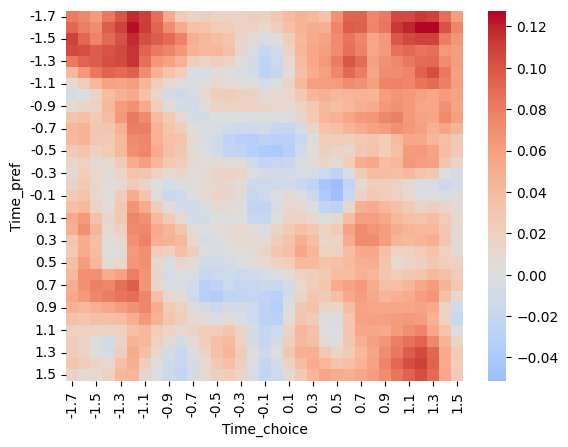

In [8]:
pivoted = avg_res.pivot(index="Time_pref", columns="Time_choice", values="cosine_sim", )
sns.heatmap(pivoted, cmap='coolwarm', center=0)